# BENAR, PAKE YANG INI

-------------------------

In [5]:
# !pip install tensorflow keras numpy opencv-python

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Mengunduh dataset dari GitHub
!git clone https://github.com/mldinaalni/urtabirsurya.git

# Menentukan direktori dataset
root_dir = './urtabirsurya/kulit'
train_data_dir = os.path.join(root_dir, "train")
test_data_dir = os.path.join(root_dir, "test")
valid_data_dir = os.path.join(root_dir, "valid")


Cloning into 'urtabirsurya'...
remote: Enumerating objects: 1681, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1681 (delta 0), reused 6 (delta 0), pack-reused 1675
Receiving objects: 100% (1681/1681), 55.32 MiB | 34.16 MiB/s, done.
Resolving deltas: 100% (1/1), done.


**Membuat Generator**

In [2]:
# Path ke data
data_dir = '/content/urtabirsurya'

# Membuat generator data untuk augmentasi gambar dan skala gambar
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Menyiapkan data generator
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),
    batch_size=50,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(299, 299),
    batch_size=50,
    class_mode='categorical'
)

# test_generator = test_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=(299, 299),
#     batch_size=50,
#     class_mode='categorical'
# )


Found 1120 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


**Memastikan Data dan Label Terbaca dengan Benar**

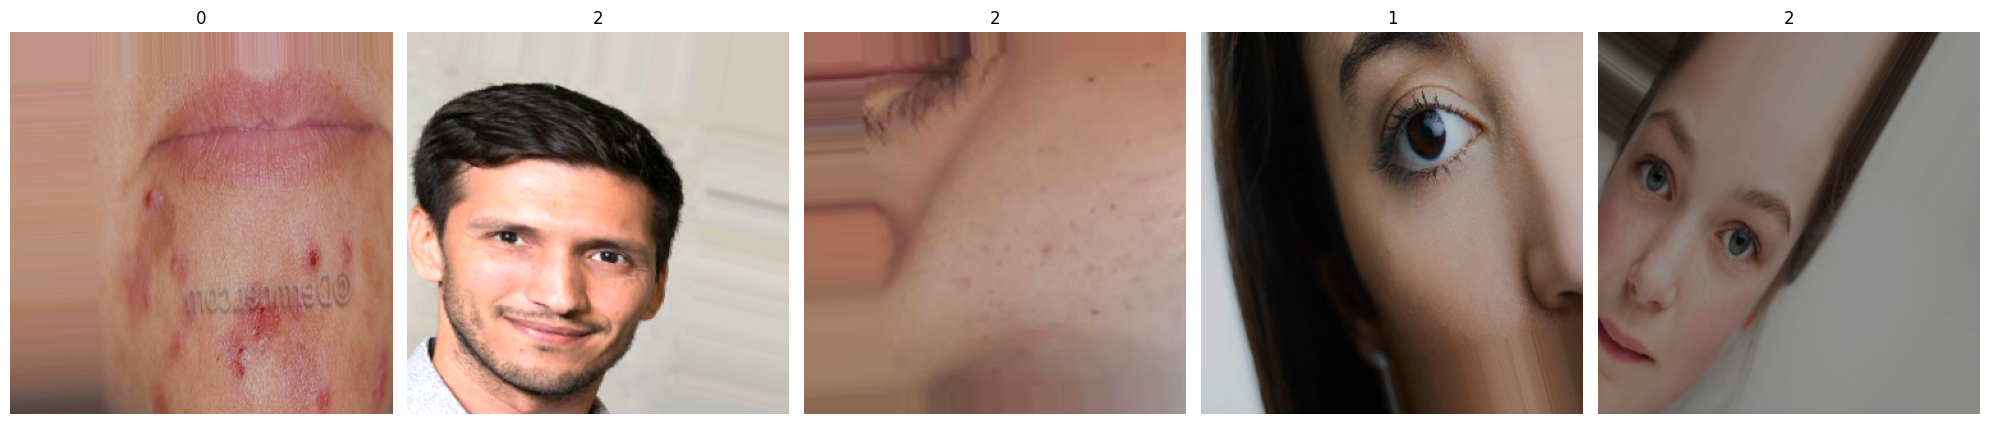

In [3]:
# Contoh penggunaan untuk memuat dan menampilkan beberapa gambar dari generator
import matplotlib.pyplot as plt

# Menampilkan beberapa gambar dari train_generator
sample_training_images, sample_training_labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(lbl.argmax())
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(sample_training_images[:5], sample_training_labels[:5])


**Menampilkan Ringkasan Data**

In [4]:
print(f"Total training samples: {train_generator.samples}")
print(f"Total validation samples: {valid_generator.samples}")
# print(f"Total testing samples: {test_generator.samples}")

print(f"Class indices: {train_generator.class_indices}")

Total training samples: 1120
Total validation samples: 330
Class indices: {'berminyak': 0, 'kering': 1, 'normal': 2}


Langkah-langkah ini akan membantu memuat dan melabeli data gambar sebelum memulai proses pembangunan model. Pastikan  sudah menyesuaikan path direktori dan parameter sesuai dengan dataset nya. (NML)

**Membangun Model**

### test

In [5]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3),
    pooling='avg'
)

for layer in base_model.layers:
  layer.trainable = False

model = base_model.output
model = Dense(128, activation='relu')(model)
model = Dropout(.5)(model)
model = Dense(256, activation='relu')(model)
model = Dropout(.5)(model)
model = Dense(512, activation='relu')(model)
model = Dropout(.5)(model)
output_layer = Dense(train_generator.num_classes, activation='softmax')(model)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

83683744/83683744 [==============================] - 1s 0us/step


**Kompilasi Model**

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkPoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


**Melatih Model**

In [7]:
# callback = myCallback() # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    # validation_steps=valid_generator.samples // valid_generator.batch_size,
    verbose = 1,
    epochs=100,
    callbacks = [early_stopping, checkPoint]
)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.0261 - accuracy: 0.5063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 66s 2s/step - loss: 1.0261 - accuracy: 0.5063 - val_loss: 1.0268 - val_accuracy: 0.4606
Epoch 2/100
23/23 [==============================] - 37s 2s/step - loss: 1.0021 - accuracy: 0.5241 - val_loss: 1.0064 - val_accuracy: 0.4606
Epoch 3/100
23/23 [==============================] - 37s 2s/step - loss: 0.9628 - accuracy: 0.5357 - val_loss: 0.9870 - val_accuracy: 0.4788
Epoch 4/100
23/23 [==============================] - 43s 2s/step - loss: 0.9527 - accuracy: 0.5339 - val_loss: 0.9713 - val_accuracy: 0.5212
Epoch 5/100
23/23 [==============================] - 37s 2s/step - loss: 0.9400 - accuracy: 0.5491 - val_loss: 0.9592 - val_accuracy: 0.5545
Epoch 6/100
23/23 [==============================] - 37s 2s/step - loss: 0.9299 - accuracy: 0.5732 - val_loss: 0.9353 - val_accuracy: 0.5545
Epoch 7/100
23/23 [==============================] - 37s 2s/step - loss: 0.8992 - accuracy: 0.5830 - val_loss: 0.9091 - val_accuracy: 0.5545
Epoch 8/100
23/23 [======

In [15]:
loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)
loss, accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Validasi Accuracy: {val_accuracy * 100:.2f}')

22/22 [==============================] - 32s 1s/step - loss: 0.3939 - accuracy: 0.8391
Test Accuracy: 83.91%
Validasi Accuracy: 77.00


**Menyimpan Model**

In [10]:
model.save('skin_type_model_baru.h5')

**Prediksi**

In [8]:
def predict_skin_type(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299,299))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    skin_type = np.argmax(prediction)
    return skin_type


In [20]:
import cv2
image_path = '752kd5y464t011-Copy_jpg.rf.9965ed3eb405e09843aa188e7e05a76d.jpg'
print(f'Predicted Skin Type: {predict_skin_type(image_path)}')

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


rekomendasi produk


In [21]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Kamus rekomendasi produk
recommendations = {
    'kering': 'Gunakan sunscreen dengan sifat melembabkan.',
    'berminyak': 'Gunakan sunscreen yang bebas minyak dan non-komedogenik.',
    'normal': 'Gunakan sunscreen spektrum luas yang cocok untuk semua jenis kulit.'
}

# Load the trained model
model_path = '/content/skin_type_model_baru.h5'  # Ganti dengan path ke model Anda yang benar
model = tf.keras.models.load_model(model_path)

# Define image size
img_height, img_width = 299, 299  # Pastikan ukuran ini sesuai dengan input model Anda

# Function to classify skin type and give recommendation
def recommend_sunscreen(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the skin type
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Mapping index to skin type
    skin_types = ['berminyak', 'kering', 'normal']  # Sesuaikan dengan kelas yang Anda miliki
    skin_type = skin_types[predicted_class[0]]

    # Get the recommendation
    recommendation = recommendations[skin_type]

    return skin_type, recommendation

# Contoh penggunaan
image_path = '/content/kulit-normal.jpg'  # Ganti dengan path gambar uji yang benar
skin_type, recommendation = recommend_sunscreen(image_path)
print(f"Predicted skin type: {skin_type}")
print(f"Recommendation: {recommendation}")

# Menampilkan gambar produk sunscreen yang sesuai
def show_sunscreen_products(skin_type):
    product_dir = os.path.join('/content/urtabirsurya/produk_sunscreen', skin_type)  # Ganti dengan direktori produk Anda yang benar
    if not os.path.exists(product_dir):
        print(f"No products found for skin type: {skin_type}")
        return

    product_images = os.listdir(product_dir)

    for img_name in product_images:
        img_path = os.path.join(product_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        plt.imshow(img_array)
        plt.title(f'Produk Sunscreen untuk kulit {skin_type}')
        plt.axis('off')
        plt.show()

# Menampilkan produk yang sesuai dengan jenis kulit yang diprediksi
show_sunscreen_products(skin_type)


1/1 [==============================] - 1s 1s/step
Predicted skin type: normal
Recommendation: Gunakan sunscreen spektrum luas yang cocok untuk semua jenis kulit.
No products found for skin type: normal
